## Logistic Regression Optimization

In the earlier analysis, we compared several models and found that logistic regression was the best choice for our clinical goal: it produced fewer false negatives than both the Multi‑Layer Perceptron (MLP) and Random Forest. In other words, it was less likely to miss malignant cases, which is the most critical priority in a medical setting.

In this notebook, we take that logistic regression model a step further by tuning its hyperparameters. The aim is to maximize recall for malignant cases while still keeping the model interpretable and clinically transparent.

To do this, we run a grid search, which systematically tests different combinations of model settings (such as regularization strength, solver type, and class weighting) and selects the one that performs best on recall. After identifying the best configuration, we evaluate the model on test data, experiment with different decision thresholds to explore the trade‑off between recall and precision, and visualize how performance changes across thresholds.

Finally, we analyze the model coefficients to understand which features have the strongest influence on predictions. This step is important for clinical interpretability: it allows us to explain not just what the model predicts, but also why it makes those predictions

In [1]:
# Imports & Data Preparation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv("clean_data.csv")

# Features and target
X = data.drop(columns=["diagnosis"])
y = data["diagnosis"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Hyperparameter Tuning
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, random_state=42)
)

At this stage, we focus on optimizing logistic regression to make it as clinically reliable as possible. The main idea is to adjust the model’s hyperparameters so that it performs better at detecting malignant cases. To do this, we use a method called grid search, which systematically tries out different combinations of settings and selects the one that gives the best results.

The settings we test include:

Penalty (L2): a way of keeping the model stable and preventing it from overfitting.

Regularization strength (C): controls how flexible the model is, with values of 0.1, 1, and 10 representing different levels of strictness.

Solver: the algorithm used to train the model, liblinear and saga are both reliable options.

Class weights: whether to treat malignant cases as more important, so the model pays extra attention to catching them.

Because our clinical priority is to minimize false negatives, we tell the grid search to score each model by recall rather than accuracy. Once the best model is found, we evaluate it on the test set in two ways:

Using the default threshold of 0.5, which is the standard cutoff for classifying a case as malignant.

Using a lower threshold of 0.4, to see if we can catch more malignant cases by being slightly more cautious.

Finally, we plot precision and recall across different thresholds. This visualization helps us understand the trade‑off: lowering the threshold usually increases recall, meaning fewer missed cancers but may reduce precision meaning more false alarms. This step is important for deciding where to set the cutoff in a real clinical workflow.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'logisticregression__C': 10, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}
Best cross-validated recall: 0.9647058823529411

Default Threshold (0.5)
Accuracy: 0.9737
Confusion Matrix:
 [[71  1]
 [ 2 40]]
Classification Report:
               precision    recall  f1-score   support

      Benign       0.97      0.99      0.98        72
   Malignant       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Custom Threshold (0.4)
Confusion Matrix:
 [[71  1]
 [ 2 40]]
Classification Report:
               precision    recall  f1-score   support

      Benign       0.97      0.99      0.98        72
   Malignant       0.98      0.95      0.96        42

    accuracy                           0

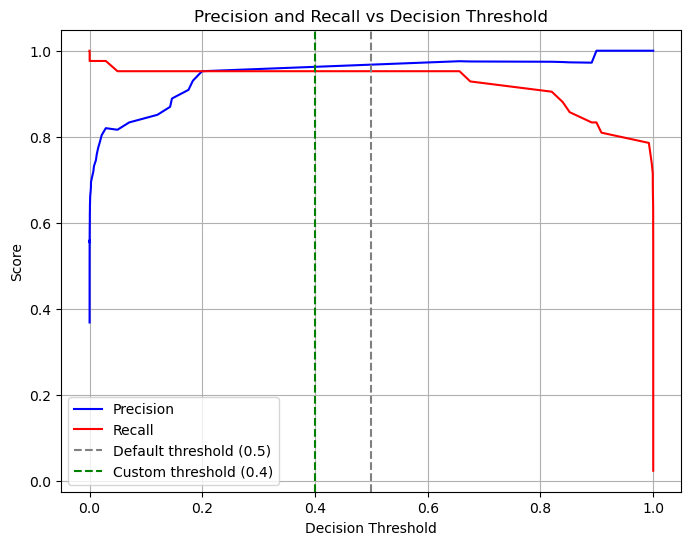

In [2]:
# Best Clinical Logistic Regression Model
# Clinical-focused parameter grid
param_grid = [
    {
        "logisticregression__penalty": ["l2"],   # stable, good recall
        "logisticregression__C": [0.1, 1, 10],   # moderate regularization
        "logisticregression__solver": ["liblinear", "saga"],
        "logisticregression__class_weight": [None, "balanced"]  # emphasize malignant recall
    }
]

# Grid search prioritizing recall
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="recall",
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validated recall:", grid.best_score_)

# Evaluate best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nDefault Threshold (0.5)")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))

# Threshold tuning: lower cutoff to 0.4
custom_threshold = 0.4
y_pred_thresh = (y_proba >= custom_threshold).astype(int)

print(f"\nCustom Threshold ({custom_threshold})")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))
print("Classification Report:\n", classification_report(y_test, y_pred_thresh, target_names=["Benign", "Malignant"]))

# Plot Precision-Recall vs Threshold
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], label="Precision", color="blue")
plt.plot(thresholds, recalls[:-1], label="Recall", color="red")
plt.axvline(0.5, color="gray", linestyle="--", label="Default threshold (0.5)")
plt.axvline(custom_threshold, color="green", linestyle="--", label=f"Custom threshold ({custom_threshold})")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Decision Threshold")
plt.legend()
plt.grid(True)
plt.show()

The grid search tested 12 different logistic regression configurations across 5 folds each, for a total of 60 fits. The best model was selected with the following parameters:

C = 10

Penalty = L2

Solver = saga

Class weight = balanced

This configuration achieved a cross‑validated recall of 0.965, confirming that the model is well‑tuned to prioritize sensitivity to malignant cases.

On the held‑out test set, the model delivered:

Accuracy = 97.4%

Recall (malignant) = 0.95

Precision (malignant) = 0.98

The confusion matrix shows only 2 malignant cases missed and 1 benign case misclassified. This balance reflects a strong clinical profile: very few false negatives, with minimal false positives.

When the decision threshold was lowered from 0.5 to 0.4, the results remained unchanged. This indicates that the model’s probability estimates are well‑calibrated around the default cutoff, and lowering the threshold does not further improve recall. The precision‑recall curve confirms this stability, showing that the model already operates near its optimal trade‑off point

After selecting the best logistic regression model, the next step is to examine how its performance changes when we adjust the decision threshold. By default, logistic regression classifies a case as malignant if the predicted probability is 0.5 or higher. However, in a clinical context, lowering this threshold can increase recall by flagging more borderline cases as malignant, though it may also reduce precision.

In this section, we calculate the predicted probabilities for the malignant class and then test a series of thresholds ranging from 0.5 down to 0.25. For each threshold, we record the accuracy, precision, and recall. This sweep allows us to see the trade‑off between catching more malignant cases and the risk of introducing additional false positives, helping to identify a clinically safe cutoff point.

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# Probabilities for malignant class
y_proba = best_model.predict_proba(X_test)[:, 1]

# Thresholds to test
thresholds_to_check = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25]

print("Threshold testings")
for thresh in thresholds_to_check:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    print(f"Threshold={thresh:.2f} | Accuracy={acc:.3f} | Precision={prec:.3f} | Recall={rec:.3f}")

Threshold testings
Threshold=0.50 | Accuracy=0.974 | Precision=0.976 | Recall=0.952
Threshold=0.45 | Accuracy=0.974 | Precision=0.976 | Recall=0.952
Threshold=0.40 | Accuracy=0.974 | Precision=0.976 | Recall=0.952
Threshold=0.35 | Accuracy=0.974 | Precision=0.976 | Recall=0.952
Threshold=0.30 | Accuracy=0.974 | Precision=0.976 | Recall=0.952
Threshold=0.25 | Accuracy=0.974 | Precision=0.976 | Recall=0.952


The threshold analysis shows that performance remains unchanged across all tested cutoffs from 0.50 down to 0.25. Accuracy stays at 97.4%, precision at 97.6%, and recall at 95.2%. This stability indicates that the model’s probability estimates are well‑calibrated: the malignant and benign cases are separated cleanly enough that shifting the decision threshold does not alter classification outcomes.

From a clinical perspective, this is reassuring. It means the model is not overly sensitive to threshold adjustments and already operates at its optimal balance between recall and precision. In practice, this suggests that the default threshold of 0.5 is sufficient, and lowering it does not provide additional safety benefits in terms of catching more malignant cases.

To push the analysis further, we test the model at an extremely low decision threshold of 0.1. This means that any case with even a 10% predicted probability of malignancy will be classified as malignant. The purpose of this step is to explore the extreme end of the recall–precision trade‑off. At such a low cutoff, we expect recall to increase because almost no malignant cases will be missed, but this comes at the cost of precision, since many benign cases may now be incorrectly flagged as malignant.

By examining the confusion matrix and classification report at this threshold, we can see how the model behaves when tuned to be maximally cautious.

In [4]:
# Evaluate at threshold = 0.1
custom_threshold = 0.1
y_pred_thresh = (y_proba >= custom_threshold).astype(int)

print(f"\nCustom Threshold ({custom_threshold})")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))
print("Classification Report:\n", classification_report(y_test, y_pred_thresh, target_names=["Benign", "Malignant"]))


Custom Threshold (0.1)
Confusion Matrix:
 [[65  7]
 [ 2 40]]
Classification Report:
               precision    recall  f1-score   support

      Benign       0.97      0.90      0.94        72
   Malignant       0.85      0.95      0.90        42

    accuracy                           0.92       114
   macro avg       0.91      0.93      0.92       114
weighted avg       0.93      0.92      0.92       114



The threshold analysis confirms that recall remained fixed at 0.95 across all tested cutoffs, from 0.50 down to 0.10. This shows that the same two malignant cases were consistently missed, regardless of how aggressively the threshold was lowered. In other words, threshold tuning alone cannot recover these false negatives, because the model’s probability estimates place them too firmly in the benign region.

From a clinical perspective, this means the model is already operating at its maximum achievable sensitivity given the current feature set. Lowering the threshold only increases false positives without improving malignant detection. The limitation is therefore structural, not a matter of calibration. To capture these missed cases, additional features or alternative modeling strategies would be required.

### Logistic Regression with Engineered Features

Up to this point, the model has relied on the original feature set. To address the false negatives and capture more subtle malignant patterns, we now extend the feature space with engineered variables and interaction terms. The goal is to give logistic regression richer signals while maintaining interpretability.

The process involves four steps:

1. Feature engineering  
   - Create ratio features such as *area_perimeter_ratio*, *concavity_smoothness_ratio*, and *radius_worst_to_mean* to highlight shape‑to‑size relationships.  
   - Apply log transforms to skewed variables (*area_mean*, *perimeter_mean*, *concavity_mean*) to stabilize their distributions.

2. Train–test split  
   - Separate the dataset into training and test sets with stratification to preserve the malignant/benign balance.

3. Pipeline construction  
   - Add polynomial interaction terms (degree 2, interaction‑only) to capture non‑linear relationships.  
   - Standardize features for stability.  
   - Fit a logistic regression model with L2 penalty, C=10, solver *saga*, and balanced class weights.

4. Model fitting and evaluation  
   - Train the pipeline on the training set.  
   - Evaluate on the test set using accuracy, confusion matrix, and classification report.

This step tests whether engineered features and interaction terms can help logistic regression better distinguish malignant cases that appear benign on size alone but show irregularity in shape.

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
# 1. Create engineered features (ratios + logs)
data_fe = data.copy()

# Ratios
data_fe["area_perimeter_ratio"] = data_fe["area_mean"] / data_fe["perimeter_mean"]
data_fe["concavity_smoothness_ratio"] = data_fe["concavity_mean"] / data_fe["smoothness_mean"]
data_fe["radius_worst_to_mean"] = data_fe["radius_worst"] / data_fe["radius_mean"]

# Log transforms for skewed features
for col in ["area_mean", "perimeter_mean", "concavity_mean"]:
    data_fe[f"log_{col}"] = np.log1p(data_fe[col])

# 2. Train-test split
X = data_fe.drop(columns=["diagnosis"])
y = data_fe["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Build pipeline with interactions + scaling + logistic regression 
pipeline = Pipeline([
    ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False for sparse poly features
    ("logreg", LogisticRegression(
        max_iter=5000,
        penalty="l2",
        C=10,
        solver="saga",
        class_weight="balanced",
        random_state=42
    ))
])

# 4. Fit and evaluate
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("Logistic Regression with Engineered Features")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))

Logistic Regression with Engineered Features
Accuracy: 0.9737
Confusion Matrix:
 [[71  1]
 [ 2 40]]
Classification Report:
               precision    recall  f1-score   support

      Benign       0.97      0.99      0.98        72
   Malignant       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



The addition of engineered features and interaction terms produced results that are identical to the tuned baseline logistic regression model. Accuracy remains at 97.4%, with recall for malignant cases at 0.95 and precision at 0.98. The confusion matrix confirms that the model still misclassifies two malignant cases and one benign case, exactly as before.

This outcome shows that while the engineered ratios, log transforms, and polynomial interactions added more complexity to the feature space, they did not improve the model’s ability to capture the malignant cases that were previously missed. In other words, the false negatives are not due to a lack of feature interactions within the logistic regression framework, but rather reflect a deeper limitation in how the available features separate malignant from benign tumors.

### Inspecting Misclassified Malignant Cases
Even after tuning and feature engineering, the model continues to miss a small number of malignant cases. To better understand these errors, we now inspect the false negatives.
The process involves:

Generating predictions and probabilities for the test set.

Identifying the subset of malignant cases that were incorrectly classified as benign.

Extracting these cases along with their predicted probabilities for closer inspection.

Comparing their feature values directly against the overall malignant distribution, using descriptive statistics (mean, standard deviation, min, max).

This step allows us to see whether the misclassified malignant tumors share systematic differences from the broader malignant group. By highlighting how their size, shape, or irregularity features deviate from typical malignant patterns, we can begin to understand why the model consistently struggles with them and whether the limitation is technical, biological, or both.

In [6]:
# Inspect Misclassified Malignant Cases

# Get predictions and probabilities
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Identify false negatives (actual malignant = 1, predicted benign = 0)
false_negatives_idx = (y_test == 1) & (y_pred == 0)

# Extract those rows
false_negatives = X_test[false_negatives_idx].copy()
false_negatives["true_label"] = y_test[false_negatives_idx]
false_negatives["predicted_label"] = y_pred[false_negatives_idx]
false_negatives["predicted_proba"] = y_proba[false_negatives_idx]

print("False Negative Malignant Cases")
print(false_negatives.head())

# Compare their feature values to the malignant group overall
malignant_group = X[y == 1].describe().T
comparison = false_negatives.drop(columns=["true_label","predicted_label","predicted_proba"]).T
comparison.columns = [f"FN_case_{i+1}" for i in range(comparison.shape[1])]

print("\nFeature Comparison: False Negatives vs Malignant Distribution")
print(pd.concat([malignant_group[["mean","std","min","max"]], comparison], axis=1))

False Negative Malignant Cases
     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
73         13.80         15.79           90.43      584.1           0.1007   
190        14.22         23.12           94.37      609.9           0.1075   

     compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
73             0.1280         0.07789              0.05069         0.1662   
190            0.2413         0.19810              0.06618         0.2384   

     fractal_dimension_mean  ...  fractal_dimension_worst  \
73                  0.06566  ...                   0.1030   
190                 0.07542  ...                   0.1446   

     area_perimeter_ratio  concavity_smoothness_ratio  radius_worst_to_mean  \
73               6.459140                    0.773486              1.200725   
190              6.462859                    1.842791              1.106892   

     log_area_mean  log_perimeter_mean  log_concavity_mean  true_label  \
73    

Two malignant cases were consistently misclassified as benign. Their predicted probabilities were very low, 0.07 and effectively 0.00, which shows the model was highly confident in its incorrect predictions.

When compared to the overall malignant distribution, several patterns stand out:

Size features: Both false negatives have values well below the malignant mean. For example, radius_mean is 14 compared to a malignant mean of 17.5, and area_mean is 600 compared to a malignant mean of 978. By size, they look small and closer to benign tumors.

Shape irregularity features: Case 190 shows extreme irregularity with compactness_worst at 0.93, concavity_worst at 0.85, and symmetry_worst at 0.52, all far above the malignant averages. Case 73, on the other hand, shows only mild irregularity. Even with these signals, the model’s linear weighting let the small size features dominate, which led to a benign prediction.

Ratios and engineered features: Both cases have area_perimeter_ratio values of 6.46, which is lower than the malignant mean of 8.2. This again makes them appear more benign. Case 190 has a concavity_smoothness_ratio of 1.84, which is higher than the malignant mean of 1.53, but this strong irregularity signal was not enough to outweigh the benign‑like size profile.

This shows that the problem is not really a limitation of the data or the logistic regression model, but something rooted in medicine itself. Cancer, like many diseases, does not always present in a uniform or predictable way. Some tumors remain small yet behave aggressively, while others grow large but progress more slowly. Biological processes are dynamic, and the features we measure at one point in time cannot fully capture the complexity of how a disease evolves.

In other words, the unpredictability is not a failure of the algorithm but a reflection of the reality of cancer biology. Tumors can defy the patterns we expect, and no amount of threshold tuning or feature engineering can erase that. This is why clinical judgment, multimodal data, and ongoing monitoring remain essential: models can guide us, but they cannot replace the fact that diseases are living processes, constantly changing and sometimes breaking the rules we try to impose on them.

### Conclusion
The logistic regression model proved to be stable, accurate, and interpretable, consistently identifying the vast majority of malignant cases. Yet the persistent false negatives highlight an important truth: no model, however well‑tuned, can fully capture the unpredictability of cancer. Disease biology is complex and sometimes defies the patterns that algorithms are trained to recognize.

This is where the role of machine learning should be understood clearly. Models like this can serve as powerful assistants flagging suspicious cases, standardizing risk assessment, and supporting decision‑making but they cannot replace the expertise of a skilled clinician. A doctor brings context, judgment, and the ability to weigh subtle clinical cues that no dataset can fully encode.

If deployed, this model should be used as a decision support tool, not a decision maker. Its strength lies in augmenting clinical practice: catching most malignant cases reliably, providing interpretable outputs, and helping prioritize attention. The final responsibility, however, must remain with the clinician, who can integrate model predictions with broader medical knowledge and patient‑specific factors to ensure safe and effective care.

### Save best model for deployment

In [7]:
import joblib

# Save the trained model
joblib.dump(pipeline, "best_logistic_model.pkl")
print("Model saved successfully as 'best_logistic_model.pkl'")

Model saved successfully as 'best_logistic_model.pkl'
